Retrieved From:
https://github.com/deepchem/deepchem/blob/master/examples/tutorials/22_Transfer_Learning_With_ChemBERTa_Transformers.ipynb

# Setup for running DeepChem in Colab

In [ ]:
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3501  100  3501    0     0  20354      0 --:--:-- --:--:-- --:--:-- 20354


python version: 3.7.10
remove current miniconda
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit, openmm, pdbfixer
added conda-forge to channels
added omnia to channels


In [ ]:
!pip install --pre deepchem
import deepchem
deepchem.__version__

NVIDIA's Apex tool: allows for 16-bit training, mixed precision, and distributed training. 

Also installing `simple-transformers`, which builds ontop of HuggingFace's transformers package specifically for fine-tuning ChemBERTa.

In [ ]:
!git clone https://github.com/NVIDIA/apex
!cd /content/apex
!pip install -v --no-cache-dir /content/apex
!pip install transformers
!pip install simpletransformers
!pip install wandb
!cd ..

In [ ]:
import sys
!test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
# !rm -r bertviz_repo # Uncomment if you need a clean pull from repo
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
  sys.path += ['bertviz_repo']
!pip install regex

Also cloning bert-loves-chemistry, which Chris used to make his RoBERTa

In [ ]:
!git clone https://github.com/seyonechithrananda/bert-loves-chemistry.git

In [ ]:
# Test if NVIDIA apex training tool works
from apex import amp

# Load the Base Model

Base classes PreTrainedTokenizer and PreTrainedTokenizerFast in HuggingFace implement common methods for encoding string inputs in model inputs and instantiating/saving python tokenizers

PreTrainedTokenize implements the following for using all tokenizers:
- Tokenizing , converting tokens strings to ids and back, and encoding/decoding 
- Adding new tokens to the vocabulary in a way that is independant of the underlying structure (ex. BPE)
- Managing special tokens like mask, beginning-of-sentence, etc tokens.

Load the model's Byte-Pair Encoding tokenizer, and model, and setup a Huggingface pipeline for masked token prediction.

In [ ]:
from transformers import AutoModelForMaskedLM, AutoTokenizer, pipeline, RobertaModel, RobertaTokenizer
from bertviz import head_view

model = AutoModelForMaskedLM.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k")
tokenizer = AutoTokenizer.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k")

fill_mask = pipeline('fill-mask', model=model, tokenizer=tokenizer)

ChemBERTa employs a bidirectional training context to learn context-aware representations of the [PubChem 10M dataset](https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/pubchem_10m.txt.zip).

12 attention heads and 6 layers -> 72 distinct attention mechanisms.

Sanity check to ensure pretrained roBERTA understands SMILES grammar using masked token prediction of a Benzene ring

In [ ]:
smiles_mask = "C1=CC=CC<mask>C1"
smiles = "C1=CC=CC=C1"

masked_smi = fill_mask(smiles_mask)

for smi in masked_smi:
  print(smi)

# Visualized Sanity Check

In [ ]:
import torch
import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import rdFMCS
from matplotlib import colors
from rdkit.Chem import Draw
from rdkit.Chem.Draw import MolToImage
from PIL import Image

def get_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    Chem.Kekulize(mol)
    return mol

def find_matches_one(mol,submol):
    #find all matching atoms for each submol in submol_list in mol.
    match_dict = {}
    mols = [mol,submol] #pairwise search
    res=rdFMCS.FindMCS(mols) #,ringMatchesRingOnly=True)
    mcsp = Chem.MolFromSmarts(res.smartsString)
    matches = mol.GetSubstructMatches(mcsp)
    return matches

#Draw the molecule
def get_image(mol,atomset):    
    hcolor = colors.to_rgb('green')
    if atomset is not None:
        #highlight the atoms set while drawing the whole molecule.
        img = MolToImage(mol, size=(600, 600),fitImage=True, highlightAtoms=atomset,highlightColor=hcolor)
    else:
        img = MolToImage(mol, size=(400, 400),fitImage=True)
    return img

In [ ]:
sequence = f"C1=CC=CC={tokenizer.mask_token}1"
substructure = "CC=CC"
image_list = []

input = tokenizer.encode(sequence, return_tensors="pt")
mask_token_index = torch.where(input == tokenizer.mask_token_id)[1]

token_logits = model(input)[0]
mask_token_logits = token_logits[0, mask_token_index, :]

top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()

for token in top_5_tokens:
  smi = (sequence.replace(tokenizer.mask_token, tokenizer.decode([token])))
  print (smi)
  smi_mol = get_mol(smi)
  substructure_mol = get_mol(substructure)
  if smi_mol is None: # if the model's token prediction isn't chemically feasible
    continue
  Draw.MolToFile(smi_mol, smi+".png")
  matches = find_matches_one(smi_mol, substructure_mol)
  atomset = list(matches[0])
  img = get_image(smi_mol, atomset)
  img.format="PNG" 
  image_list.append(img)

C1=CC=CC=CC1
C1=CC=CC=CCC1
C1=CC=CC=CN1
C1=CC=CC=CCCC1
C1=CC=CC=CCO1


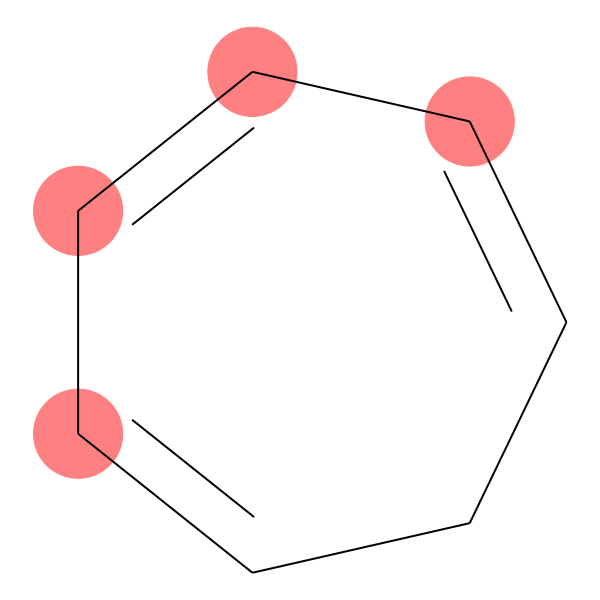

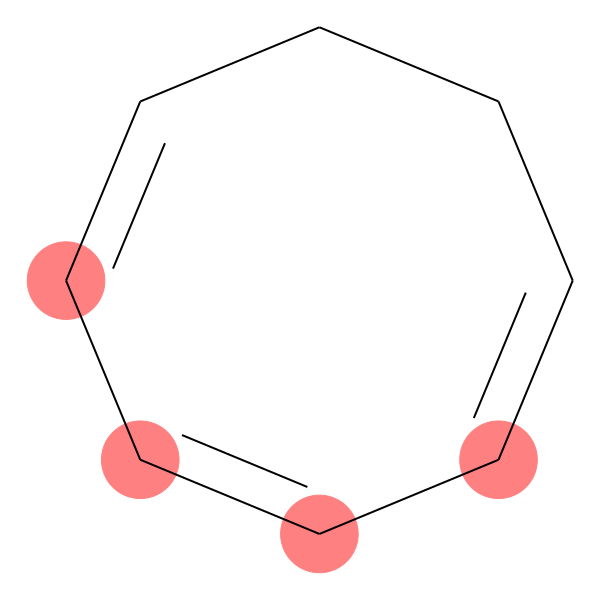

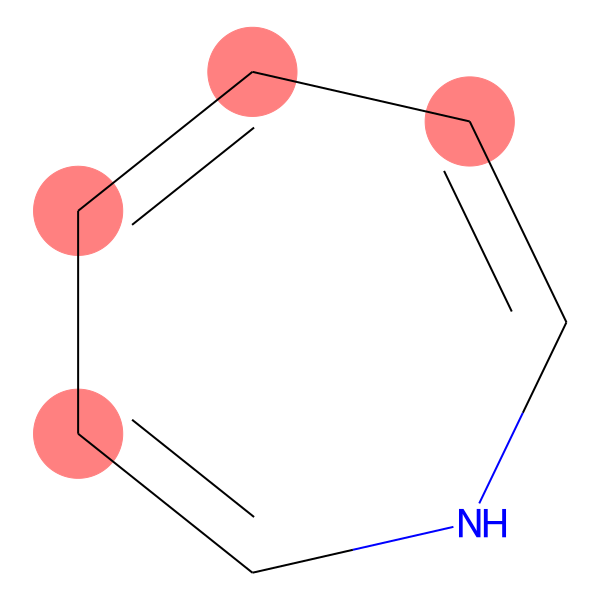

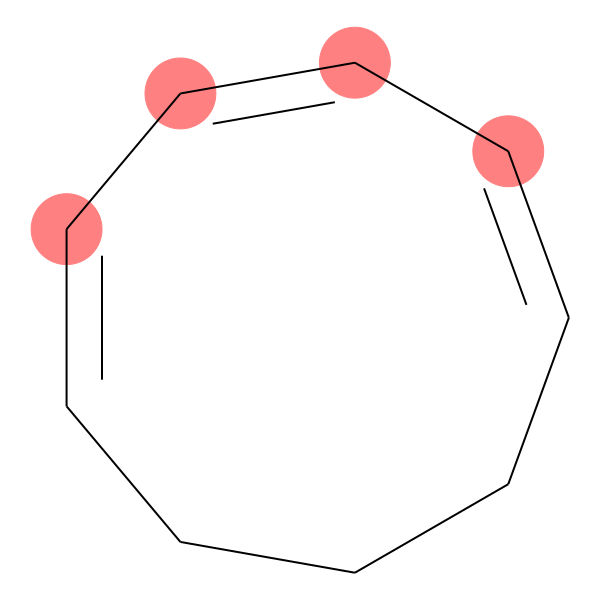

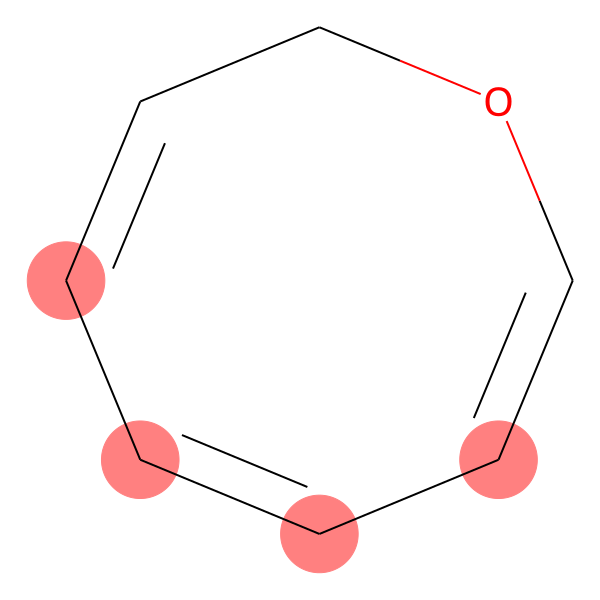

In [ ]:
from IPython.display import Image 

for img in image_list:
  display(img)

All 5 MLM predictions are chemically valid

# Visualization of Attention Mechanism in ChemBERTa using BertViz 

BertViz extends the Tensor2Tensor visualization tool by Llion Jones and the transformers library from HuggingFace

Obtain a Javascript object for d3.js and jquery to create interactive visualizations:

In [ ]:
%%javascript
require.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min',
      jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
  }
});

<IPython.core.display.Javascript object>

In [ ]:
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.8/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

Create an instance of ChemBERTa, tokenize a set of SMILES strings, and compute the attention for each head in the transformer

Take two SMILES molecules from the ZINC database with nearly identical chemical structure, the only difference being rooted in chiral specification, the only difference being orientation of a single branch in space ('@' vs '@@')

The model should ideally refer to similar substructures in each SMILES string with a higher attention weightage.

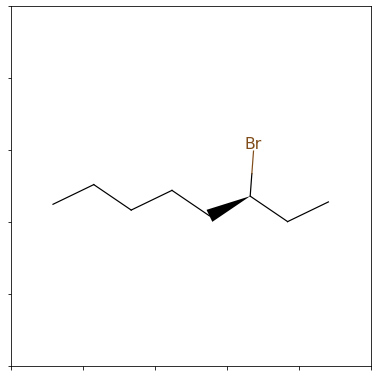

In [ ]:
m1 = Chem.MolFromSmiles('CCCCC[C@@H](Br)CC')
fig = Draw.MolToMPL(m1, size=(200, 200))

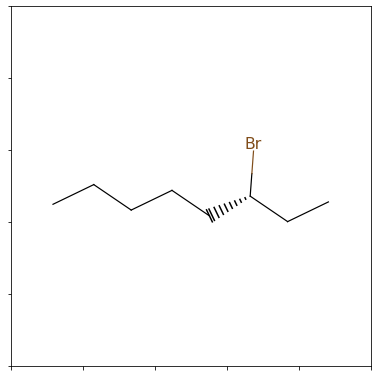

In [ ]:
m2 = Chem.MolFromSmiles('CCCCC[C@H](Br)CC')
fig = Draw.MolToMPL(m2, size=(200,200))

In [ ]:
from transformers import RobertaModel, RobertaTokenizer
from bertviz import head_view

model_version = 'seyonec/PubChem10M_SMILES_BPE_450k'
model = RobertaModel.from_pretrained(model_version, output_attentions=True)
tokenizer = RobertaTokenizer.from_pretrained(model_version)

sentence_a = "CCCCC[C@@H](Br)CC"
sentence_b = "CCCCC[C@H](Br)CC"
inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True)
input_ids = inputs['input_ids']
attention = model(input_ids)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)

call_html()

head_view(attention, tokens)

<IPython.core.display.Javascript object>

Visualization shows that attention is highest between words that don’t cross a boundary between the two SMILES strings (this is a good thing)

# Fine-tuning BPE-ChemBERTa for Another Dataset (similar to Chris' implementation)

In [ ]:
%cd /content/bert-loves-chemistry

/content/bert-loves-chemistry


In [ ]:
import os

import numpy as np
import pandas as pd

from typing import List

# import molnet loaders from deepchem
from deepchem.molnet import load_bbbp, load_clearance, load_clintox, load_delaney, load_hiv, load_qm7, load_tox21
from rdkit import Chem

# import MolNet dataloder from bert-loves-chemistry fork
from chemberta.utils.molnet_dataloader import load_molnet_dataset, write_molnet_dataset_for_chemprop

In [ ]:
!wget https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/vocab.txt

--2021-04-18 17:57:45--  https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/vocab.txt
Resolving deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)... 52.219.113.17
Connecting to deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)|52.219.113.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3524 (3.4K) [text/plain]
Saving to: ‘vocab.txt’

vocab.txt           100%[===================>]   3.44K  --.-KB/s    in 0s      

2021-04-18 17:57:46 (212 MB/s) - ‘vocab.txt’ saved [3524/3524]



In [ ]:
tasks, (train_df, valid_df, test_df), transformers = load_molnet_dataset("clintox", tasks_wanted=None)

'split' is deprecated.  Use 'splitter' instead.
Failed to featurize datapoint 7, None. Appending empty array
Exception message: Python argument types in
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True)
Failed to featurize datapoint 302, None. Appending empty array
Exception message: Python argument types in
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True)
Failed to featurize datapoint 983, None. Appending empty array
Exception message: Python argument types in
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True)
Failed to featurize datapoint 

Using tasks ['CT_TOX'] from available tasks for clintox: ['FDA_APPROVED', 'CT_TOX']


In [ ]:
train_df

,text,labels
0,CC(C)C[C@H](NC(=O)CNC(=O)c1cc(Cl)ccc1Cl)B(O)O,0
1,O=C(NCC(O)CO)c1c(I)c(C(=O)NCC(O)CO)c(I)c(N(CCO...,1
2,Clc1cc(Cl)c(OCC#CI)cc1Cl,1
3,N#Cc1cc(NC(=O)C(=O)[O-])c(Cl)c(NC(=O)C(=O)[O-])c1,1
4,NS(=O)(=O)c1cc(Cl)c(Cl)c(S(N)(=O)=O)c1,1
...,...,...
1177,CC(C[NH2+]C1CCCCC1)OC(=O)c1ccccc1,1
1178,CC(C(=O)[O-])c1ccc(C(=O)c2cccs2)cc1,1
1179,CC(c1cc2ccccc2s1)N(O)C(N)=O,1
1180,CC(O)C(CO)NC(=O)C1CSSCC(NC(=O)C([NH3+])Cc2cccc...,1


They set up a logger but I'm not going to run it for now since this is a tutorial

In [ ]:
#from simpletransformers.classification import ClassificationModel
# import logging
# logging.basicConfig(level=logging.INFO)
# transformers_logger = logging.getLogger("transformers")
# transformers_logger.setLevel(logging.WARNING)

In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs

model = ClassificationModel('roberta', 'seyonec/PubChem10M_SMILES_BPE_396_250', 
                            args={'evaluate_each_epoch': True, 
                                  'evaluate_during_training_verbose': True, 
                                  'no_save': True, 
                                  'num_train_epochs': 10, 
                                  'auto_weights': True}) 
# You can set class weights by using the optional weight argument

Some weights of the model checkpoint at seyonec/PubChem10M_SMILES_BPE_396_250 were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/PubChem10M_SMILES_BPE_396_250 and are newly initialized: ['classifier.dense.weigh

In [ ]:
# check if our train and evaluation dataframes are setup properly. 
#There should only be two columns for the SMILES string and its corresponding label.
print("Train Dataset: {}".format(train_df.shape))
print("Eval Dataset: {}".format(valid_df.shape))
print("TEST Dataset: {}".format(test_df.shape))

Train Dataset: (1182, 2)
Eval Dataset: (148, 2)
TEST Dataset: (148, 2)


Train the model on the train scaffold set of ClinTox

In [ ]:
# !wandb login
# !mkdir BPE_PubChem_10M_ClinTox_run

In [ ]:
# Train the model
model.train_model(train_df, eval_df=valid_df, 
                  output_dir='/content/test_1', 
                  # args={'wandb_project': 'project-name'}
                  )

  0%|          | 0/1182 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/148 [00:00<?, ?it/s]

(1480, 0.11799510212180934)

Evaluate the Model

In [ ]:
import sklearn

# accuracy
result, model_outputs, wrong_predictions = model.eval_model(test_df, acc=sklearn.metrics.accuracy_score)
print(result)
# ROC-PRC
result, model_outputs, wrong_predictions = model.eval_model(test_df, acc=sklearn.metrics.average_precision_score)
print(result)

  0%|          | 0/148 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

{'mcc': 0.6092582763756147, 'tp': 137, 'tn': 5, 'fp': 4, 'fn': 2, 'auroc': 0.858113509192646, 'auprc': 0.9877636843927451, 'acc': 0.9594594594594594, 'eval_loss': 0.2155110255874828}


  0%|          | 0/148 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

{'mcc': 0.6092582763756147, 'tp': 137, 'tn': 5, 'fp': 4, 'fn': 2, 'auroc': 0.858113509192646, 'auprc': 0.9877636843927451, 'acc': 0.9711644140696643, 'eval_loss': 0.2155110255874828}


# Benchmarking Alternative Smiles-Tokenizer ChemBERTa

In [ ]:
model = ClassificationModel('roberta', 
                            'seyonec/SMILES_tokenized_PubChem_shard00_160k', 
                            args={'evaluate_each_epoch': True, 
                                  'evaluate_during_training_verbose': True, 
                                  'no_save': True, 
                                  'num_train_epochs': 15, 
                                  'auto_weights': True}) 
# You can set class weights by using the optional weight argument

Some weights of the model checkpoint at seyonec/SMILES_tokenized_PubChem_shard00_160k were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/SMILES_tokenized_PubChem_shard00_160k and are newly initialized: ['classi

In [ ]:
# !wandb login
# # Create directory to store model weights (change path accordingly to where you want!)
# !mkdir SmilesTokenizer_PubChem_10M_ClinTox_run

In [ ]:
# Train the model
model.train_model(train_df, eval_df=valid_df, 
                  output_dir='/content/test_2', 
                  # args={'wandb_project': 'project-name'}
                  )

  0%|          | 0/1182 [00:00<?, ?it/s]

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Running Epoch 0 of 15:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 1 of 15:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 2 of 15:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 3 of 15:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 4 of 15:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 5 of 15:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 6 of 15:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 7 of 15:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 8 of 15:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 9 of 15:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 10 of 15:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 11 of 15:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 12 of 15:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 13 of 15:   0%|          | 0/148 [00:00<?, ?it/s]

Running Epoch 14 of 15:   0%|          | 0/148 [00:00<?, ?it/s]

(2220, 0.12158582765199147)

In [ ]:
import sklearn

# accuracy
result, model_outputs, wrong_predictions = model.eval_model(test_df, acc=sklearn.metrics.accuracy_score)
print(result)

# ROC-PRC
result, model_outputs, wrong_predictions = model.eval_model(test_df, acc=sklearn.metrics.average_precision_score)
print(result)

  0%|          | 0/148 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

{'mcc': 0.21509151163240414, 'tp': 138, 'tn': 1, 'fp': 8, 'fn': 1, 'auroc': 0.7829736211031175, 'auprc': 0.9781660957045177, 'acc': 0.9391891891891891, 'eval_loss': 0.3084223472048363}


  0%|          | 0/148 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

{'mcc': 0.21509151163240414, 'tp': 138, 'tn': 1, 'fp': 8, 'fn': 1, 'auroc': 0.7829736211031175, 'auprc': 0.9781660957045177, 'acc': 0.9451621967882932, 'eval_loss': 0.3084223472048363}


# How do we TF-ize this thing???

Credit to Chris for laying most of the groundwork, just tweaking a bit of the dataset arhitecture and utilizing different tokenizers

## Load the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
train_path = '/content/drive/MyDrive/DATA_2040/Molecular Exploration/Data/SR-p53_train.txt'
whole_train_path = '/content/drive/MyDrive/DATA_2040/Molecular Exploration/Data/SR-p53_wholetraining.txt'
test_path = '/content/drive/MyDrive/DATA_2040/Molecular Exploration/Data/SR-p53_test.txt'

train_path = '/content/drive/MyDrive/Molecular Exploration/Data/SR-p53_train.txt'
whole_train_path = '/content/drive/MyDrive/Molecular Exploration/Data/SR-p53_wholetraining.txt'
test_path = '/content/drive/MyDrive/Molecular Exploration/Data/SR-p53_test.txt'

train_srp53 = pd.read_csv(train_path,
                          sep='\s+',
                          names=['smiles', 'target'])

whole_train_srp53 = pd.read_csv(whole_train_path,
                          sep='\s+',
                          names=['smiles', 'target'])

test_srp53 = pd.read_csv(test_path,
                          sep='\s+',
                          names=['smiles', 'target'])

In [ ]:
# get the unique union of wholetrain and train as our train dataset

train_concat = train_srp53.append(whole_train_srp53).drop_duplicates(subset=['smiles'])
print(train_concat.shape)
train_concat.head()

(7194, 2)


,smiles,target
0,CCN1C(=CC=Cc2sc3ccccc3[n+]2CC)Sc2ccccc21.[I-],1
1,COC(=O)C[C@](O)(CCCC(C)(C)O)C(=O)O[C@@H]1C(OC)...,1
2,Cc1cccc(C)c1OCC(C)N.Cl,0
3,CO.COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)c(OC...,1
4,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccc(O)cc3)...,0


In [ ]:
# split into train and validation
import numpy as np
np.random.seed(0)

msk = np.random.rand(len(train_concat)) < 0.8

train_df = train_concat[msk]
val_df = train_concat[~msk]

In [ ]:
train_df.head()

,smiles,target
0,CCN1C(=CC=Cc2sc3ccccc3[n+]2CC)Sc2ccccc21.[I-],1
1,COC(=O)C[C@](O)(CCCC(C)(C)O)C(=O)O[C@@H]1C(OC)...,1
2,Cc1cccc(C)c1OCC(C)N.Cl,0
3,CO.COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)c(OC...,1
4,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccc(O)cc3)...,0


In [ ]:
def read_molnet_df(df):
    texts = []
    labels = []

    for index, row in df.iterrows():
      texts.append(row['smiles'])
      labels.append(row['target'])

    return texts, labels


# train_texts, train_labels = read_molnet_df(train_srp53)
train_texts, train_labels = read_molnet_df(train_df)
## ignoring validation data for now, just want to see if there are any category errors
val_texts, val_labels = read_molnet_df(val_df)
test_texts, test_labels = read_molnet_df(test_srp53)

In [ ]:
print(len(train_texts))
print(len(train_labels))
print(len(val_texts))
print(len(val_labels))
print(len(test_texts))
print(len(test_labels))

5792
5792
1402
1402
268
268


We're gonna try a few different tokenizers trained for SMILES strings and see which one(s) perform the best

There's quite a few ([see Seyone Chithrananda's 🤗 page](https://huggingface.co/seyonec)), and I'm overwhelmed with the options so I guess we just try a few at random and see how they compare.

Another thing I don't get is the difference in performance between `RobertaTokenizerFast`, `RobertaTokenizer`, and `AutoTokenizer`. I know that `RobertaTokenizerFast` is the parent class to `RobertaTokenizer` and seems to have better functionality although I'm not sure what that may be. Since we want
RoBERTa over something more general (`Auto` in `AutoTokenizer`), we'll use `RobertaTokenizerFast`

## Tokenize Input

In [ ]:
from transformers import RobertaTokenizerFast, RobertaTokenizer, AutoTokenizer

# tokenizer1 = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
# tokenizer2 = AutoTokenizer.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k")
# tokenizer3 = AutoTokenizer.from_pretrained("seyonec/PubChem10M_SMILES_BPE_396_250")

tokenizer4 = RobertaTokenizer.from_pretrained('seyonec/PubChem10M_SMILES_BPE_450k')
# tokenizer5 = RobertaTokenizerFast.from_pretrained('seyonec/SMILES_tokenized_PubChem_shard00_160k')

In [ ]:
train_encodings = tokenizer4(train_texts, truncation=True, padding=True)
val_encodings = tokenizer4(val_texts, truncation=True, padding=True)
test_encodings = tokenizer4(test_texts, truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
print(type(train_encodings['input_ids']))
print(type(train_encodings['attention_mask']))

print(train_encodings['input_ids'][0][10])
print(train_encodings['attention_mask'][0][200])

print(type(train_labels))

<class 'list'>
<class 'list'>
23
0
<class 'list'>


In [ ]:
len(val_encodings['input_ids'][0])

212

## Build the Dataset

In [ ]:
import tensorflow as tf

class MolNetDataset():
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: tf.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = tf.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset_tf = MolNetDataset(train_encodings, train_labels)
val_dataset_tf = MolNetDataset(val_encodings, val_labels)
test_dataset_tf = MolNetDataset(test_encodings, test_labels)

In [ ]:
# Store the padded encodings in their own objects and abandoning the attention_mask
# --> maybe that's just a variable that's useful when using the ChemBERTa sequence classifier models?
train_padded = train_encodings['input_ids']
val_padded = val_encodings['input_ids']
test_padded = test_encodings['input_ids']

In [ ]:
padded_x_train = np.expand_dims(np.asarray(train_padded),-1)
padded_x_val = np.expand_dims(np.asarray(val_padded),-1)
padded_x_test = np.expand_dims(np.asarray(test_padded),-1)

In [ ]:
print(padded_x_train.shape)
print(padded_x_val.shape)
print(padded_x_test.shape)

(5792, 282, 1)
(1402, 212, 1)
(268, 117, 1)


In [ ]:
# ... and convert to tensor
tf_x_train = tf.convert_to_tensor(padded_x_train, dtype='float32')
tf_x_val = tf.convert_to_tensor(padded_x_val, dtype='float32')
tf_x_test = tf.convert_to_tensor(padded_x_test, dtype='float32')

In [ ]:
# ... and need to create the y_test and y_train
y_train = np.asarray(train_labels)
y_val = np.asarray(val_labels)
y_test = np.asarray(test_labels)

## Build the Model

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import *
# importing different layer initalizers -- LSTMS are notoriously finnicky on initialization
from tensorflow.keras.initializers import *

In [ ]:
# inspecting the masks
masking_layer = layers.Masking(mask_value=0.0)
masked_x_train = masking_layer(tf_x_train)

In [ ]:
!pip install -q wandb
import wandb

wandb.init(project="ChemBERTa_DeepChem_tox21")

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# create the model (using an adaption of Jillian and Chris' individual notebooks)
from tensorflow.keras.models import Model

keras.backend.clear_session()

def rnn_bert_model():

  model = Sequential()
  model.add(Masking(mask_value=0.0))

  model.add(Bidirectional(LSTM(256,  
                return_sequences = True),
              #    kernel_initializer=GlorotNormal,
                input_shape=(tf_x_train.shape[1],tf_x_train.shape[2])))
  
  model.add(Dropout(0.25))
  model.add(Bidirectional(LSTM(256, return_sequences = True)))
  model.add(Dropout(0.25))
  model.add(Bidirectional(LSTM(256, return_sequences = True)))

  model.add(Conv1D(64, 
                   kernel_size=3, 
                   padding='valid', 
                   kernel_initializer='glorot_uniform'))
  
  model.add(GlobalAveragePooling1D())
  model.add(Dense(1, activation='sigmoid'))

  # common metric for the binary classification problem: AUC
  auc_metric = tf.keras.metrics.AUC()
  opt = tf.keras.optimizers.Adam(learning_rate=0.01)

  model.compile(loss='binary_crossentropy', 
                optimizer=opt, 
                metrics=['accuracy', auc_metric])

  model.build(input_shape=(None,
                           tf_x_train.shape[1],
                           tf_x_train.shape[2]))
  print(model.summary())

  return model


def dense_bert_model():
  """implements a 1D CNN w/ highway module head"""

  # CNN module

  model = Sequential()
  model.add(Masking(mask_value=0.0))

  model.add(Conv1D(64, kernel_size=3, 
             padding='valid', 
             kernel_initializer='glorot_uniform'))

  model.add(LayerNormalization())
  model.add(Activation('relu'))

  model.add(Dense(16))
  model.add(Activation('relu'))

  model.add(GlobalAveragePooling1D())

  model.add(Dense(1, activation='sigmoid'))

  # common metric for the binary classification problem: AUC
  auc_metric = tf.keras.metrics.AUC()
  opt = tf.keras.optimizers.Adam(learning_rate=0.01)

  model.compile(loss='binary_crossentropy', 
                optimizer=opt, 
                metrics=['accuracy', auc_metric])

  model.build(input_shape=(None,
                           tf_x_train.shape[1],
                           tf_x_train.shape[2]))
  print(model.summary())

  return model

model = rnn_bert_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 282, 1)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 282, 512)          528384    
_________________________________________________________________
dropout (Dropout)            (None, 282, 512)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 282, 512)          1574912   
_________________________________________________________________
dropout_1 (Dropout)          (None, 282, 512)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 282, 512)          1574912   
_________________________________________________________________
conv1d (Conv1D)              (None, 280, 64)           9

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# save_path = '/content/drive/MyDrive/2040_final_project/Molecular Exploration/model_checkpoints/'
save_path = '/content/drive/MyDrive/DATA_2040/Molecular Exploration/model_checkpoints/ChemBERTa_DeepChem/'

save_name = "sequence_checkpoint-{epoch:02d}-{val_auc:.2f}.hdf5"     

checkpoint = ModelCheckpoint(save_path+save_name,
                             monitor = "val_auc",
                             mode = "max",
                             save_best_only = True,
                             verbose = 1,
                             save_weights_only = False)

earlystop = EarlyStopping(monitor = 'val_auc', 
                          min_delta = 0.001, 
                          patience = 15,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_auc',
                              factor = 0.8,
                              patience = 4,
                              verbose = 1,
                              min_delta = 0.0001,
                              min_lr = 0.00000001)

callbacks = [checkpoint, earlystop, reduce_lr,wandb.keras.WandbCallback()]

## Fit the Model

In [ ]:
# Weights to add to the loss function, emphasize the positive class

negative, positive = np.mean(y_train), 1 - np.mean(y_train)

print(positive, negative)

0.9352555248618785 0.06474447513812155


In [ ]:
model.fit(tf_x_train, 
          y_train, 
          validation_data=(tf_x_val, y_val),
          epochs=100,
          batch_size=128,
          # class_weight={0: negative, 1: positive},
          callbacks=callbacks)

Epoch 1/100
46/46 [==============================] - 539s 11s/step - loss: 3.5394 - accuracy: 0.8550 - auc: 0.5391 - val_loss: 0.2092 - val_accuracy: 0.9451 - val_auc: 0.6739

Epoch 00001: val_auc improved from -inf to 0.67391, saving model to /content/drive/MyDrive/DATA_2040/Molecular Exploration/model_checkpoints/ChemBERTa_DeepChem/sequence_checkpoint-01-0.67.hdf5
Epoch 2/100
26/46 [===============>..............] - ETA: 3:30 - loss: 0.2721 - accuracy: 0.9219 - auc: 0.5721

KeyboardInterrupt: ignored

In [ ]:
wandb.finish()

epoch,15
loss,0.2353
accuracy,0.93526
auc,0.59878
val_loss,0.21052
val_accuracy,0.94508
val_auc,0.67177
lr,0.00512
_runtime,946
_timestamp,1618769790
_step,36


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆
loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▇▇▇▇▇▇▇▇▇▇▇▇▇▆▇
accuracy,▁▂▃▃▄▃▄▄▄▃▄▄▄▄▄▄▄▄▄▄▄████████████████
auc,▁▅▆▇█▇███████▇███████▂▂▁▃▃▄▅▆▆▄▆▆▅▆▆▄
val_loss,▅█▅▇▆▇▅▆▇▅█▇▇▆█▆▇▅▆█▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▇▁▆▄▅▄▅▅▃▅▃▄▄▅▃▅▃▅▅▃▄████████████████
val_auc,██████▇█▇▇█▇▇▇▇▇▇▇▇▇▇▁▇▇▇▇█▇▇█▇█▇██▇█
lr,██████████████████▅▅▅█████▅▅▅▅▃▃▃▃▁▁▁
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂████████████████
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂████████████████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
